In [1]:
import yfinance as yf
import pandas as pd
import os

In [2]:
if os.path.exists("store.csv"):
    sp500 = pd.read_csv("store.csv", index_col=0)
else:
    sp500 = yf.Ticker("^GSPC")
    sp500 = sp500.history(period="max")
    sp500.to_csv("sp500.csv")

In [7]:
sp500["Date"] = pd.to_datetime(sp500["Date"])
sp500.set_index('Date', inplace=True)

In [8]:
sp500

,Open,High,Low,Close,Volume
Date,,,,,
2014-04-09,12593.20,12957.50,12548.50,12937.40,0
2014-04-10,12937.40,13055.60,12881.20,12949.40,0
2014-04-11,12822.20,12934.90,12778.00,12840.20,0
2014-04-15,12830.50,12831.60,12537.70,12579.90,0
2014-04-16,12557.40,12727.00,12514.80,12563.20,0
...,...,...,...,...,...
2024-04-01,47391.05,47646.80,47373.10,47578.25,0
2024-04-02,47490.75,47707.35,47408.55,47545.45,0
2024-04-03,47350.25,47676.95,47279.80,47624.25,0


<Axes: xlabel='Date'>

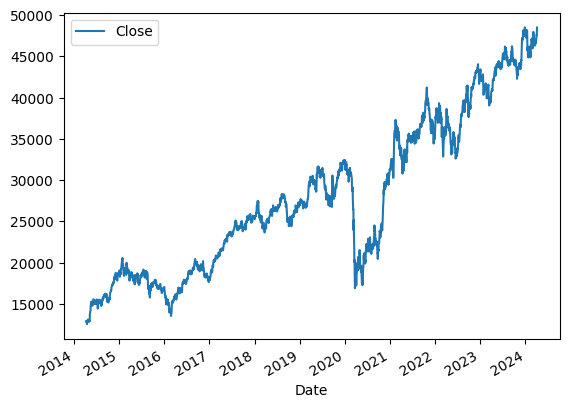

In [9]:
sp500.plot.line(y="Close", use_index=True)

In [11]:
sp500["Tomorrow"] = sp500["Close"].shift(-1)

In [12]:
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)

In [13]:
sp500 = sp500.loc["1990-01-01":].copy()

In [14]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train = sp500.iloc[:-100]
test = sp500.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [15]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.6363636363636364

<Axes: xlabel='Date'>

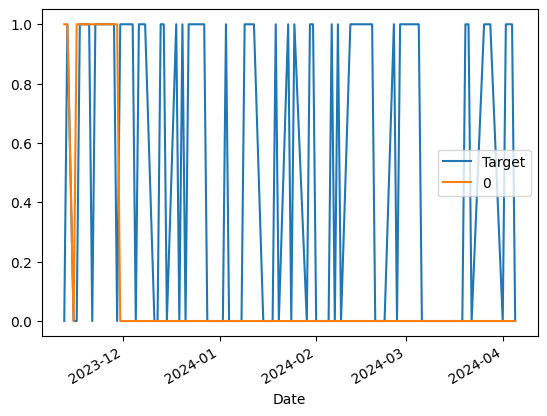

In [16]:
combined = pd.concat([test["Target"], preds], axis=1)
combined.plot()

In [17]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [18]:
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

In [19]:
predictions = backtest(sp500, model, predictors)

ValueError: No objects to concatenate

In [20]:
predictions["Predictions"].value_counts()

NameError: name 'predictions' is not defined

In [48]:
precision_score(predictions["Target"], predictions["Predictions"])

0.534777176176593

In [49]:
predictions["Target"].value_counts() / predictions.shape[0]

1    0.536075
0    0.463925
Name: Target, dtype: float64

In [50]:
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()
    
    ratio_column = f"Close_Ratio_{horizon}"
    sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"]
    
    trend_column = f"Trend_{horizon}"
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]
    
    new_predictors+= [ratio_column, trend_column]

In [53]:
sp500 = sp500.dropna(subset=sp500.columns[sp500.columns != "Tomorrow"])

In [55]:
sp500

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
1993-12-14,465.730011,466.119995,462.459991,463.059998,275050000,461.839996,0,0.997157,1.0,0.996617,1.0,1.000283,32.0,1.028047,127.0,1.176082,512.0
1993-12-15,463.059998,463.690002,461.839996,461.839996,331770000,463.339996,1,0.998681,0.0,0.995899,1.0,0.997329,32.0,1.025151,126.0,1.172676,512.0
1993-12-16,461.859985,463.980011,461.859985,463.339996,284620000,466.380005,1,1.001621,1.0,0.999495,2.0,1.000311,32.0,1.028274,127.0,1.176163,513.0
1993-12-17,463.339996,466.380005,463.339996,466.380005,363750000,465.850006,0,1.003270,2.0,1.004991,3.0,1.006561,32.0,1.034781,128.0,1.183537,514.0
1993-12-20,466.380005,466.899994,465.529999,465.850006,255900000,465.299988,0,0.999431,1.0,1.003784,2.0,1.005120,32.0,1.033359,128.0,1.181856,513.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-06,3930.889893,3942.550049,3886.750000,3908.189941,2209800080,3979.870117,1,0.997948,0.0,0.989893,1.0,0.982136,26.0,0.902791,120.0,1.103594,542.0
2022-09-07,3909.429932,3987.889893,3906.030029,3979.870117,0,4006.179932,1,1.009087,1.0,1.008370,2.0,0.999819,27.0,0.919786,121.0,1.123489,543.0
2022-09-08,3959.939941,4010.500000,3944.810059,4006.179932,0,4067.360107,1,1.003294,2.0,1.012411,3.0,1.005349,28.0,0.926253,122.0,1.130564,543.0


In [56]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [57]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >=.6] = 1
    preds[preds <.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [58]:
predictions = backtest(sp500, model, new_predictors)

In [59]:
predictions["Predictions"].value_counts()

0.0    3933
1.0     805
Name: Predictions, dtype: int64

In [60]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5701863354037268

In [61]:
predictions["Target"].value_counts() / predictions.shape[0]

1    0.546855
0    0.453145
Name: Target, dtype: float64

In [62]:
predictions

,Target,Predictions
Date,,
2003-11-14,0,0.0
2003-11-17,0,1.0
2003-11-18,1,1.0
2003-11-19,0,0.0
2003-11-20,1,1.0
...,...,...
2022-09-06,1,0.0
2022-09-07,1,0.0
2022-09-08,1,0.0
